# On Dropout Analysis in Deep Nets

Load all the necessary packages

In [1]:
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"
import theano
import keras

from keras.datasets import cifar10
from keras.models  import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN not available)
Using Theano backend.


## Train on CIFAR-10 dataset

#### Load CIFAR 10 dataset.

CIFAR-10 is the widely used dataset in deep learning community to benchmark, validate and evaluate any new findings.
CIFAR-10 dataset contains around 60k images belonging to 10 classes. It contains 50k training and 10k test images. The dataset is available at http://www.cs.toronto.edu/~kriz/cifar.html . Please visit the webpage to know more about the dataset.

In [2]:
cifar10 = np.load('./../data/data/lab2/lab2_data/cifar10_data.npz')
X_train = cifar10['X_train']
y_train = cifar10['y_train']
X_test = cifar10['X_test']
y_test = cifar10['y_test']

print "Training data:"
print "Number of examples: ", X_train.shape[0]
print "Number of channels:",X_train.shape[1] 
print "Image size:", X_train.shape[2], X_train.shape[3]
print
print "Test data:"
print "Number of examples:", X_test.shape[0]
print "Number of channels:", X_test.shape[1]
print "Image size:",X_test.shape[2], X_test.shape[3] 

Training data:
Number of examples:  50000
Number of channels: 3
Image size: 32 32

Test data:
Number of examples: 10000
Number of channels: 3
Image size: 32 32


#### Visualize some images from CIFAR-10 dataset. 
It contains 10 classes namely, airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

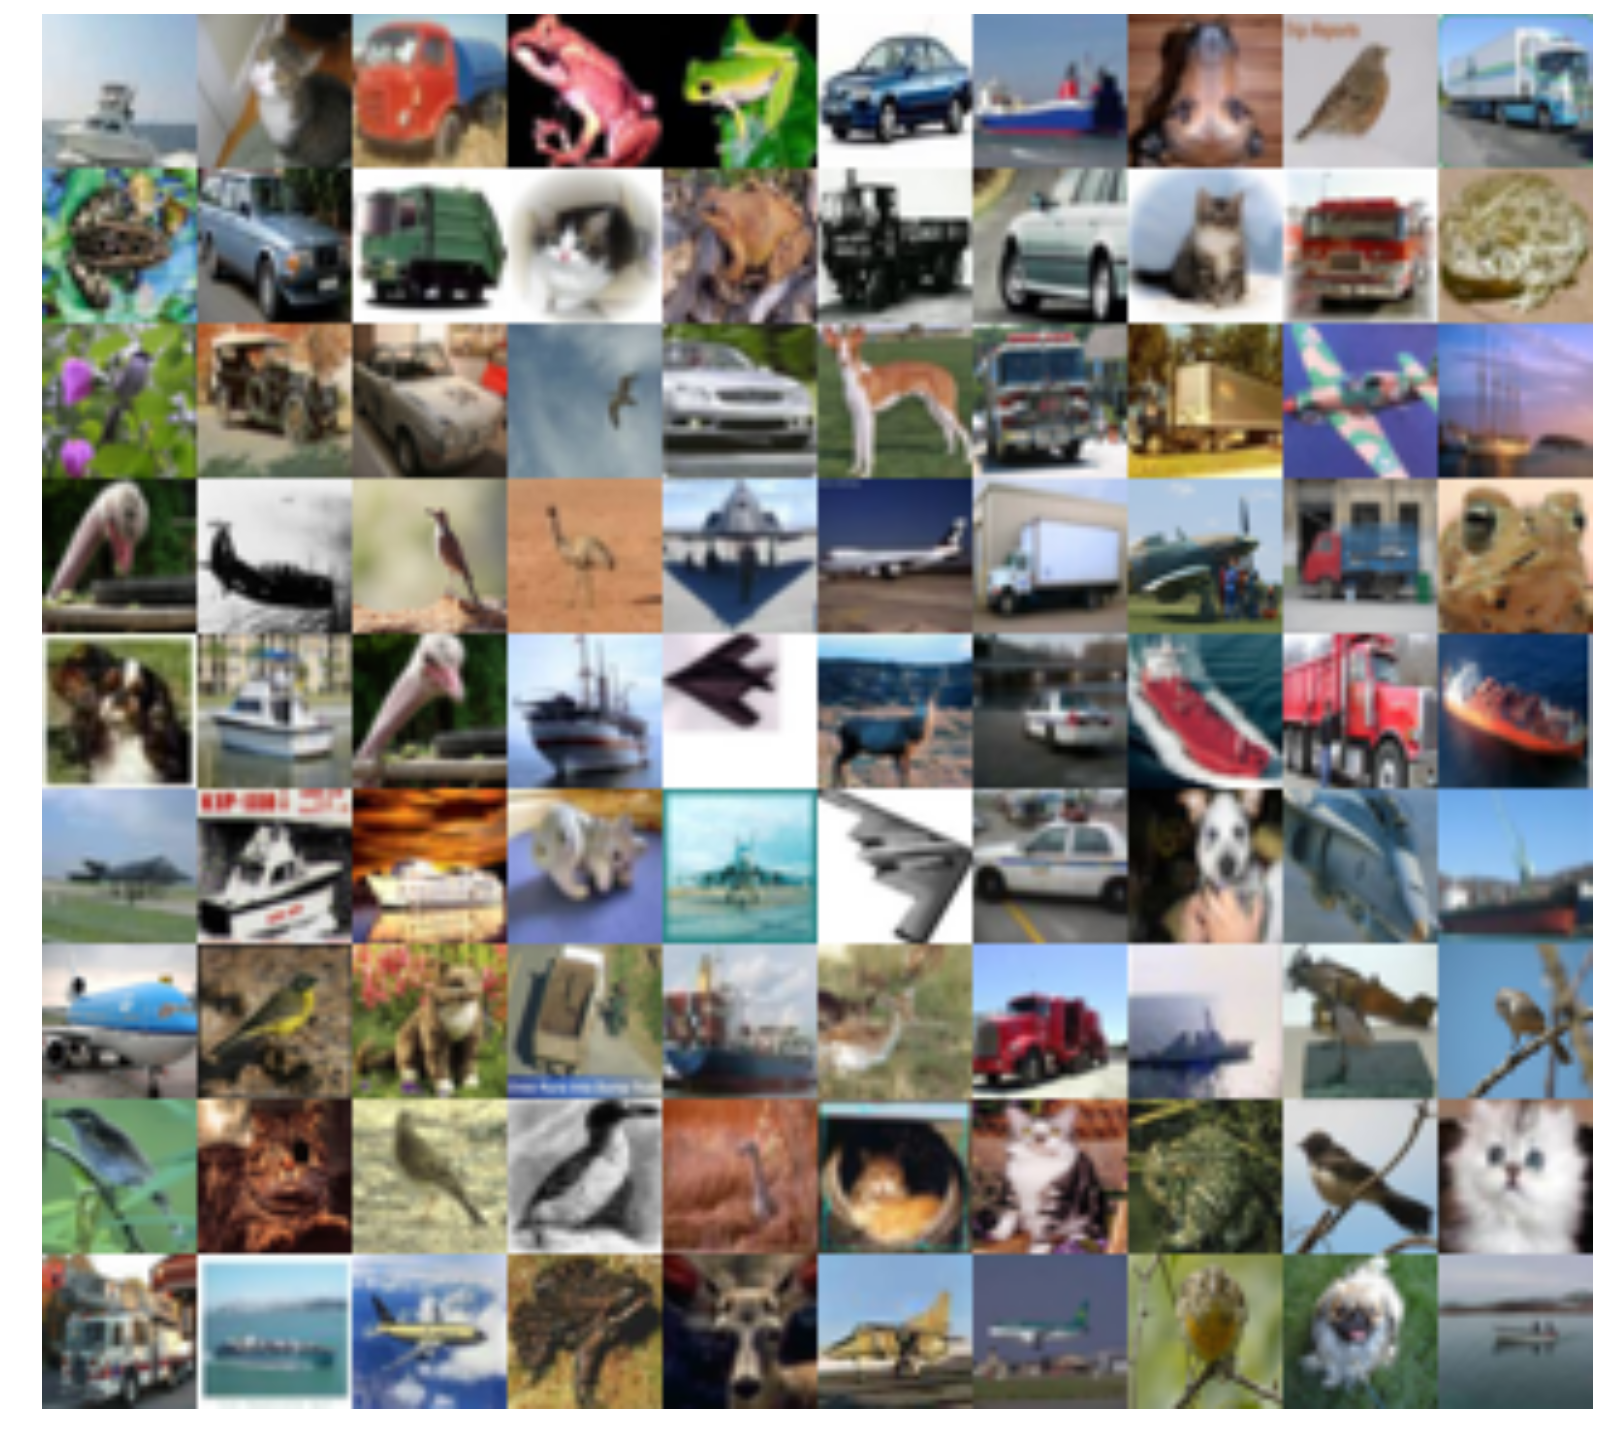

In [3]:
plot = []
for i in range(1,10):
    plot_image = X_train[100*i,:,:,:].transpose(1,2,0)
    for j in range(1,10):
        plot_image = np.concatenate((plot_image, X_train[100*i+j,:,:,:].transpose(1,2,0)), axis=1)
    if i==1:
        plot = plot_image
    else:
        plot = np.append(plot, plot_image, axis=0)

plt.imshow(plot)
plt.axis('off')
plt.show()

#### Normalize the data.

In [4]:
print "mean before normalization:", np.mean(X_train) 
print "std before normalization:", np.std(X_train)

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(X_train.shape)
newX_test = np.ones(X_test.shape)
for i in xrange(3):
    mean[i] = np.mean(X_train[:,i,:,:])
    std[i] = np.std(X_train[:,i,:,:])
    
for i in xrange(3):
    newX_train[:,i,:,:] = X_train[:,i,:,:] - mean[i]
    newX_train[:,i,:,:] = newX_train[:,i,:,:] / std[i]
    newX_test[:,i,:,:] = X_test[:,i,:,:] - mean[i]
    newX_test[:,i,:,:] = newX_test[:,i,:,:] / std[i]
        
    
X_train = newX_train
X_test = newX_test

print "mean after normalization:", np.mean(X_train)
print "std after normalization:", np.std(X_train)

mean before normalization: 120.707565124
std before normalization: 64.1500758911
mean after normalization: 5.47443571956e-17
std after normalization: 1.0


#### Specify Training Parameters

In [11]:
batchSize = 512                   #-- Training Batch Size
num_classes = 10                  #-- Number of classes in CIFAR-10 dataset
num_epochs = 100                   #-- Number of epochs for training   
learningRate= 0.001               #-- Learning rate for the network
lr_weight_decay = 0.95            #-- Learning weight decay. Reduce the learn rate by 0.95 after epoch


img_rows, img_cols = 32, 32       #-- input image dimensions

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

#### VGGnet-10

In [12]:
from keras import initializations
import copy
result = {}
y = {}
loss = []
acc = []
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for dropout in dropouts:
    print "Dropout: ", (dropout)
    model = Sequential()                                               

    #-- layer 1
    model.add(Convolution2D(64, 3, 3,                                    
                            border_mode='valid',
                            input_shape=(3, img_rows, img_cols))) 
    model.add(Dropout(dropout))  
    model.add(Convolution2D(64, 3, 3))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))                                       
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##--layer 2                        
    model.add(Convolution2D(128, 3, 3))
    model.add(Dropout(dropout)) 
    model.add(Activation('relu'))                                       
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##--layer 3                         
    model.add(Convolution2D(256, 3, 3))
    model.add(Dropout(dropout)) 
    model.add(Activation('relu'))                                       
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##-- layer 4
    model.add(Flatten())                                                
    model.add(Dense(512))                                               
    model.add(Activation('relu'))                                       

    #-- layer 5
    model.add(Dense(512))                                                
    model.add(Activation('relu'))                                       

    #-- layer 6
    model.add(Dense(num_classes))                                       

    #-- loss
    model.add(Activation('softmax'))
    
    sgd = SGD(lr=learningRate, decay = lr_weight_decay)
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    model_cce = model.fit(X_train, Y_train, batch_size=batchSize, nb_epoch=20, verbose=1, shuffle=True, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    y[dropout] = model.predict(X_test)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    result[dropout] = copy.deepcopy(model_cce.history)   
    loss.append(score[0])
    acc.append(score[1])
    
print models

Dropout:  0.0
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 28s - loss: 2.2449 - acc: 0.2104 - val_loss: 2.1653 - val_acc: 0.2505
Epoch 2/20
50000/50000 [==============================] - 28s - loss: 2.0655 - acc: 0.2766 - val_loss: 1.9637 - val_acc: 0.3023
Epoch 3/20
50000/50000 [==============================] - 28s - loss: 1.8924 - acc: 0.3260 - val_loss: 1.8261 - val_acc: 0.3539
Epoch 4/20
50000/50000 [==============================] - 28s - loss: 1.7926 - acc: 0.3608 - val_loss: 1.7504 - val_acc: 0.3739
Epoch 5/20
50000/50000 [==============================] - 28s - loss: 1.7330 - acc: 0.3813 - val_loss: 1.6658 - val_acc: 0.4041
Epoch 6/20
50000/50000 [==============================] - 28s - loss: 1.6672 - acc: 0.4064 - val_loss: 1.6243 - val_acc: 0.4271
Epoch 7/20
50000/50000 [==============================] - 28s - loss: 1.6015 - acc: 0.4304 - val_loss: 1.5474 - val_acc: 0.4435
Epoch 8/20
50000/50000 [================

NameError: name 'models' is not defined

## Plotting Results.

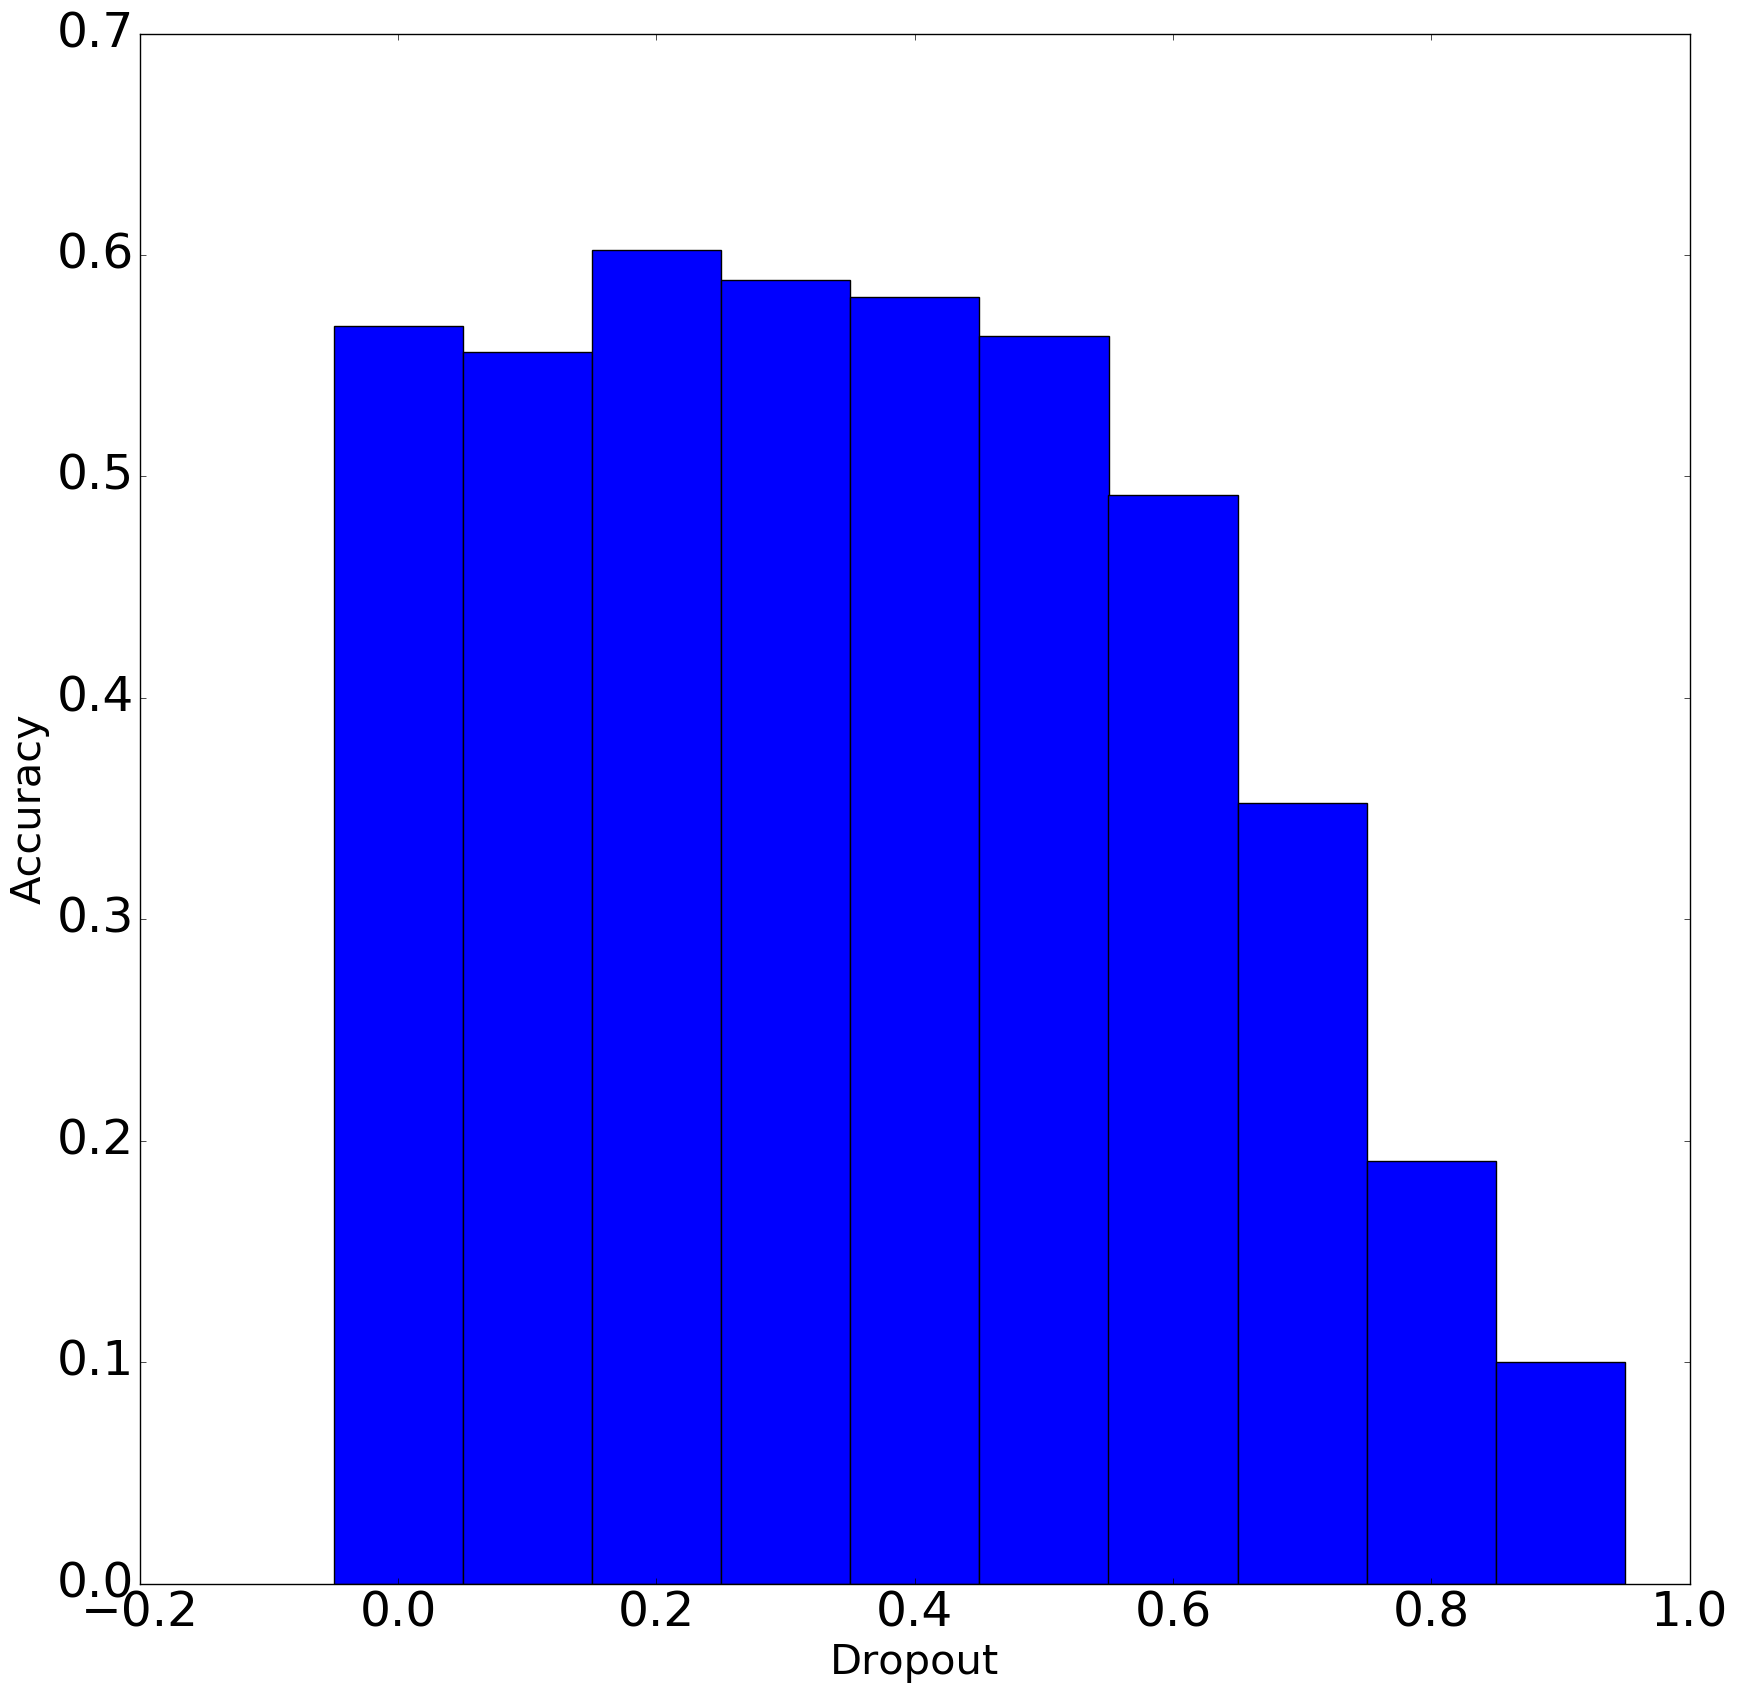

In [27]:
import numpy as np                                                               
import matplotlib.pyplot as plt

width = 0.1

plt.bar(dropouts, acc, width, align='center')

plt.tick_params(axis='both', which='major', labelsize=35)
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.ylabel('Accuracy',size = 30)
plt.xlabel('Dropout', size = 30)
plt.show()

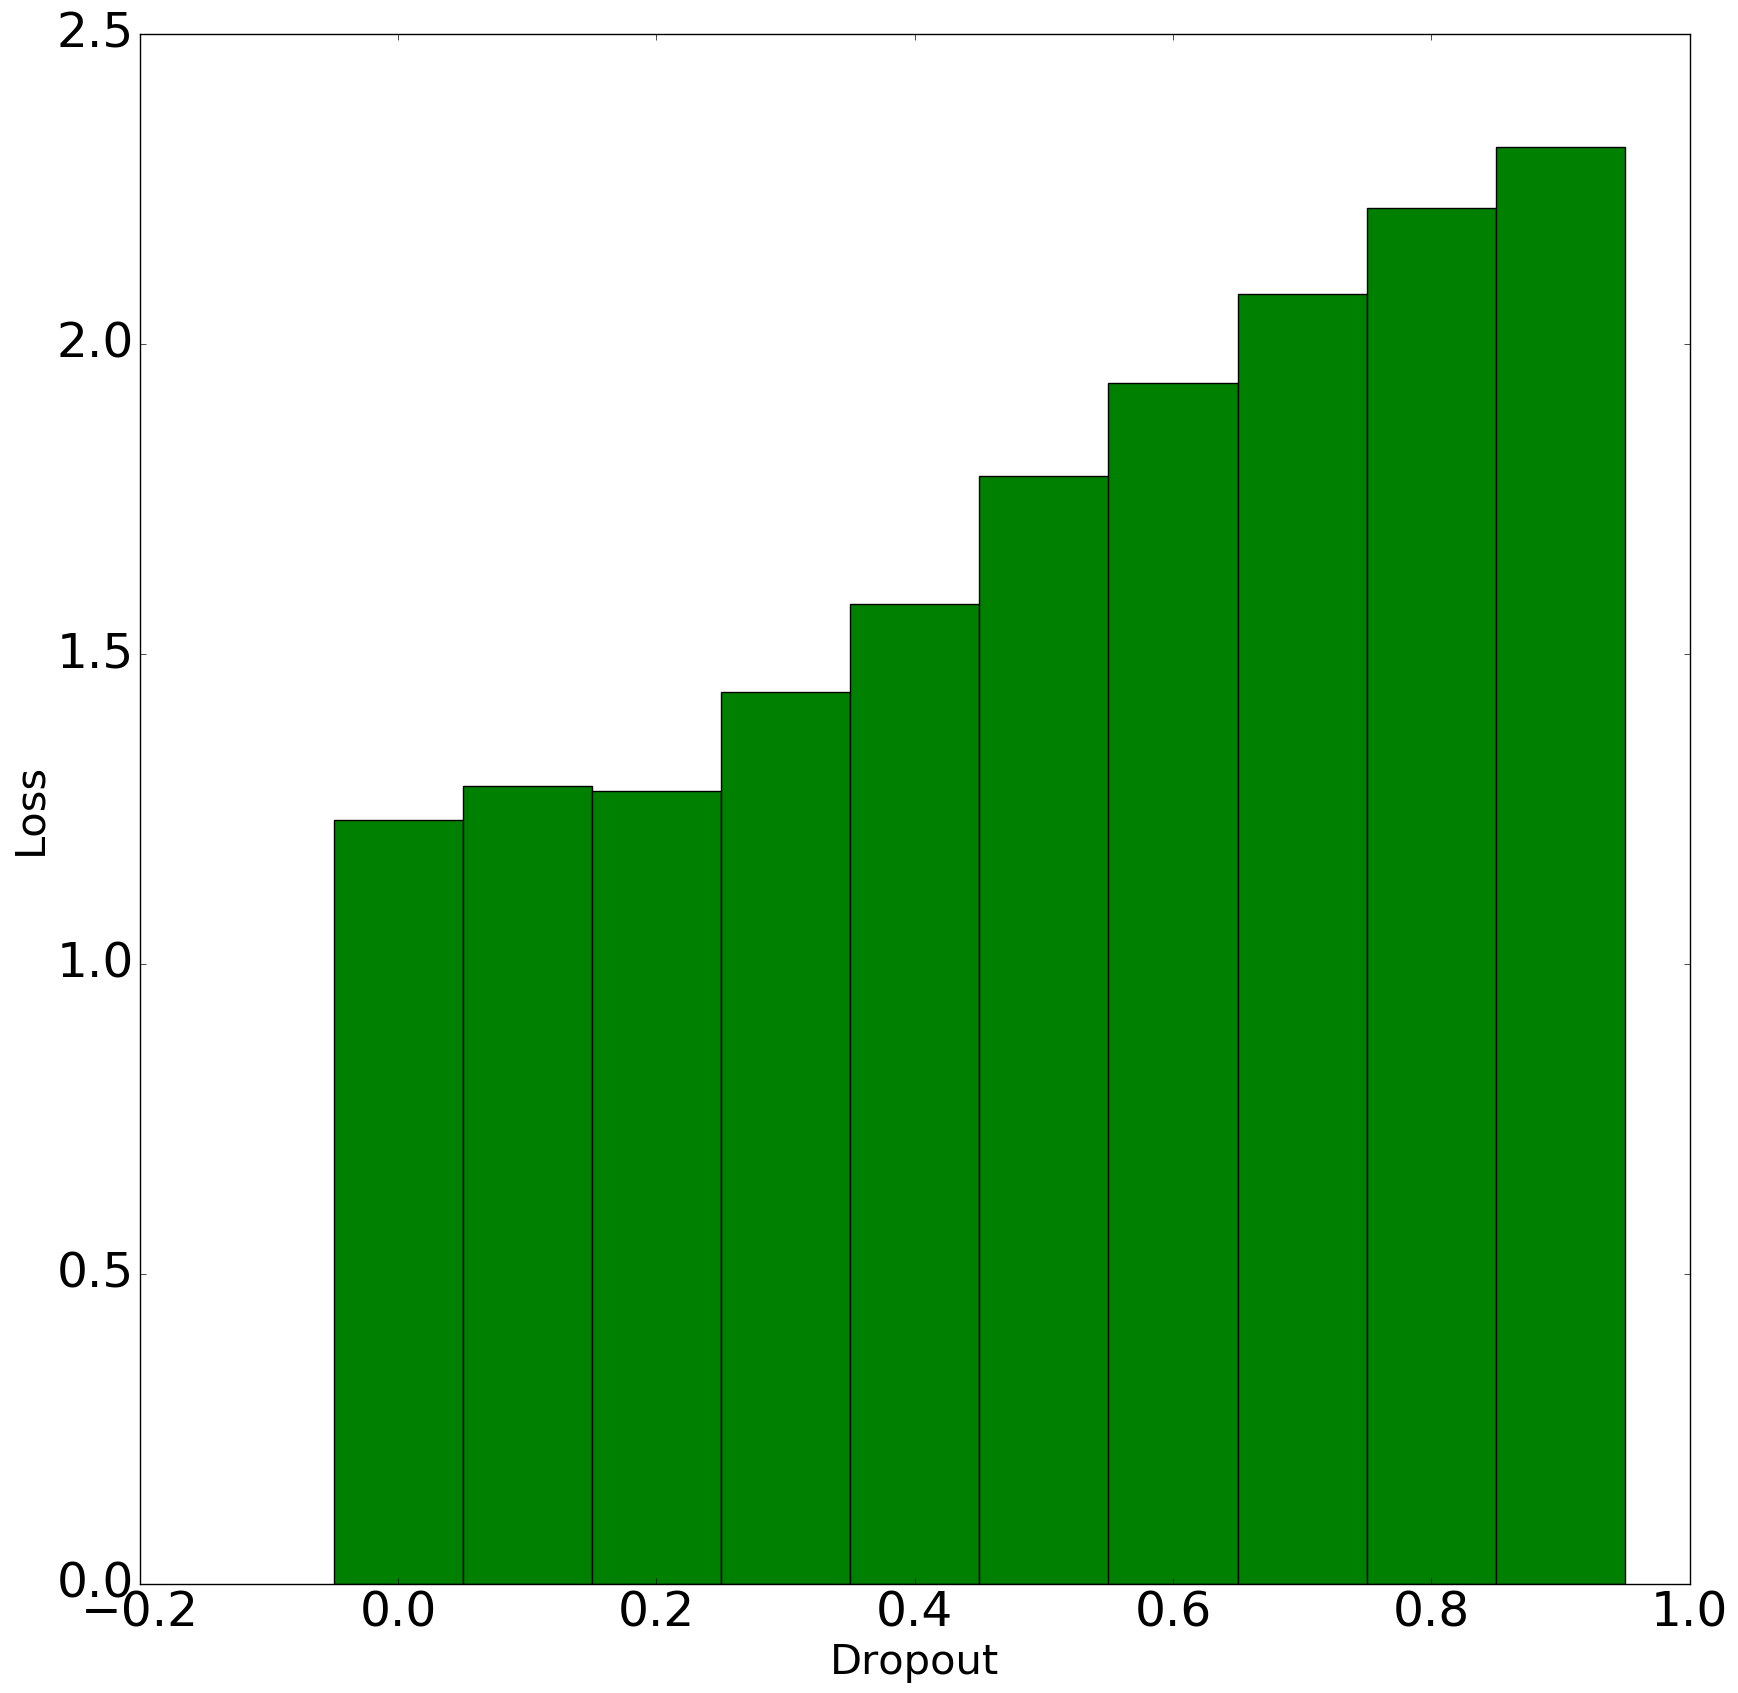

In [31]:
import numpy as np                                                               
import matplotlib.pyplot as plt

width = 0.1

plt.bar(dropouts, loss, width, align='center',color = 'green')

plt.tick_params(axis='both', which='major', labelsize=35)
plt.tick_params(axis='both', which='minor', labelsize=35)

plt.ylabel('Loss',size = 30)
plt.xlabel('Dropout', size = 30)
plt.show()